In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils import data

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn
# import resnet_cifar

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=0.5,
        std=0.5,
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
# train_dataset.data = train_dataset.data.view(-1, 28*28)
# test_dataset.data = test_dataset.data.view(-1, 28*28)
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cpu")

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
for xx, yy in train_loader:
    print(xx.shape)
    xx, yy = xx.view(-1,28*28).to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28])
torch.Size([50, 784]) torch.Size([50])


In [11]:
class LocalMLPsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = nn.LogSoftmax(dim=-1)
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
        self.activ = nn.ReLU()
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
    
        self.temp_maximum = None
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_maximum = xo.data
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

## epsilon-Softmax neurons

In [12]:
class EpsilonSoftmax(nn.Module):
    '''
    Assuming the minimum distance is below epsilon.
    '''
    def __init__(self, dim=-1, epsilon:float=0.1, maxima_above_epsilon:bool=True):
        super().__init__()
        self.dim= dim
        self.epsilon = epsilon
        self.sign = 1
        if not maxima_above_epsilon:
            self.sign = -1
            
    def forward(self, x):
        ## x shape=[batch_size, dimensions]
        bs, _ = x.shape
#         return torch.log_softmax(
        return torch.softmax(
            torch.cat([self.sign*x, torch.ones(bs, 1, device=x.device)*self.epsilon], dim=self.dim), 
            dim=self.dim)#[:, :-1]

In [13]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
#         self.layer0 = dtnn.iStereographicLinearTransform(self.input_dim, self.hidden_dim)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_Gaussian(self.input_dim, self.hidden_dim, bias=True)
        self.layer0 = dtnn.DistanceTransform_Simple(self.input_dim, self.hidden_dim, bias=True)
        self.bn = nn.BatchNorm1d(self.hidden_dim, affine=False)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = EpsilonSoftmax(dim=-1, epsilon=epsilon)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='exp_1.6')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.bn(xo)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [14]:
xx.shape

torch.Size([50, 784])

In [15]:
H = 100
model = LocalMLP_epsilonsoftmax(784, H, 10, epsilon=0.3)
model(xx).shape

torch.Size([50, 10])

In [16]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [17]:
best_acc = -1
def test(epoch, model, model_name):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
#         state = {
#             'model': model.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#         }
#         if not os.path.isdir('models'):
#             os.mkdir('models')
#         torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [19]:
model = LocalMLP_epsilonsoftmax(784, H, 10, epsilon=-200.0).to(device)
# model = LocalMLPsoftmax(784, H, 10).to(device)

model_name = f"LocalMLP_h{H}"
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Gaussian()
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (scale_shift): ScaleShift()
  (softmax): EpsilonSoftmax()
  (activ): OneActiv()
  (layer1): Linear(in_features=101, out_features=10, bias=True)
)

In [20]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [21]:
source

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [22]:
model.layer0.centers.data = source.type(torch.float32)/128-1

In [23]:
targets = torch.zeros(len(target), 10)
for i, t in enumerate(target):
    targets[i, t] = 1.

targets = torch.cat([targets, torch.randn(1, 10)], dim=0)
targets.shape

torch.Size([101, 10])

In [24]:
model.layer1.weight.data = targets.t()#.to(device)

In [25]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.bn(xo)
    xo = self.scale_shift(xo)
    xo = F.softmax(xo, dim=-1).data
#     xo = F.log_softmax(xo, dim=-1).data
#     xo = self.activ(xo)
#     xo = self.layer1(xo)
#     return xo
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 100])
tensor([0.0052, 0.0206, 0.0468, 0.0038, 0.0024, 0.0035, 0.0372, 0.0085, 0.0232,
        0.0183, 0.0038, 0.0031, 0.0168, 0.0015, 0.0195, 0.0005, 0.0054, 0.0007,
        0.0204, 0.0030, 0.0103, 0.0078, 0.0085, 0.0205, 0.0172, 0.0014, 0.0355,
        0.0062, 0.0105, 0.0163, 0.0371, 0.0035, 0.0126, 0.0051, 0.0018, 0.0035,
        0.0129, 0.0019, 0.0089, 0.0121, 0.0272, 0.0050, 0.0091, 0.0509, 0.0048,
        0.0249, 0.0028, 0.0026, 0.0046, 0.0021, 0.0040, 0.0003, 0.0004, 0.0012,
        0.0183, 0.0088, 0.0025, 0.0002, 0.0121, 0.0010, 0.0118, 0.0029, 0.0111,
        0.0035, 0.0014, 0.0017, 0.0073, 0.0068, 0.0023, 0.0037, 0.0220, 0.0401,
        0.0018, 0.0002, 0.0064, 0.0005, 0.0138, 0.0039, 0.0281, 0.0059, 0.0078,
        0.0011, 0.0061, 0.0075, 0.0209, 0.0099, 0.0320, 0.0019, 0.0030, 0.0236,
        0.0153, 0.0199, 0.0007, 0.0004, 0.0027, 0.0017, 0.0031, 0.0012, 0.0045,
        0.0005]) 
  tensor([0.0238, 0.0861, 0.1863, 0.0206, 0.0075, 0.0125, 0.1620, 0.0428, 0.1409

In [26]:
test(-1, model, model_name)

100%|██████████| 200/200 [00:01<00:00, 168.14it/s]

[Test] -1 Loss: 1.733 | Acc: 72.960 7296/10000
Saving..


In [27]:
# asdasd

In [18]:
learning_rate = 0.0001
EPOCHS = 10

In [28]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# best_acc = -1
# for epoch in range(EPOCHS):
#     train(epoch, model, optimizer)
#     test(epoch, model, model_name)
#     scheduler.step()

100%|██████████| 1200/1200 [00:09<00:00, 131.40it/s]


[Train] 0 Loss: 1.696 | Acc: 77.198 46319/60000


100%|██████████| 200/200 [00:01<00:00, 168.67it/s]


[Test] 0 Loss: 1.604 | Acc: 79.810 7981/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 130.79it/s]


[Train] 1 Loss: 1.574 | Acc: 79.207 47524/60000


100%|██████████| 200/200 [00:01<00:00, 149.16it/s]


[Test] 1 Loss: 1.493 | Acc: 81.890 8189/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 109.80it/s]


[Train] 2 Loss: 1.472 | Acc: 80.722 48433/60000


100%|██████████| 200/200 [00:01<00:00, 145.95it/s]


[Test] 2 Loss: 1.400 | Acc: 82.990 8299/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 110.56it/s]


[Train] 3 Loss: 1.388 | Acc: 81.850 49110/60000


100%|██████████| 200/200 [00:01<00:00, 148.10it/s]


[Test] 3 Loss: 1.326 | Acc: 83.960 8396/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 101.96it/s]


[Train] 4 Loss: 1.322 | Acc: 82.692 49615/60000


100%|██████████| 200/200 [00:01<00:00, 133.32it/s]


[Test] 4 Loss: 1.266 | Acc: 84.860 8486/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 109.42it/s]


[Train] 5 Loss: 1.271 | Acc: 83.340 50004/60000


100%|██████████| 200/200 [00:01<00:00, 142.12it/s]


[Test] 5 Loss: 1.224 | Acc: 85.120 8512/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 108.71it/s]


[Train] 6 Loss: 1.235 | Acc: 83.800 50280/60000


100%|██████████| 200/200 [00:01<00:00, 122.55it/s]


[Test] 6 Loss: 1.195 | Acc: 85.360 8536/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 111.14it/s]


[Train] 7 Loss: 1.212 | Acc: 84.077 50446/60000


100%|██████████| 200/200 [00:01<00:00, 139.29it/s]


[Test] 7 Loss: 1.178 | Acc: 85.720 8572/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 108.60it/s]


[Train] 8 Loss: 1.199 | Acc: 84.308 50585/60000


100%|██████████| 200/200 [00:01<00:00, 136.35it/s]


[Test] 8 Loss: 1.168 | Acc: 85.500 8550/10000


100%|██████████| 1200/1200 [00:10<00:00, 110.97it/s]


[Train] 9 Loss: 1.195 | Acc: 84.273 50564/60000


100%|██████████| 200/200 [00:01<00:00, 140.30it/s]

[Test] 9 Loss: 1.165 | Acc: 85.870 8587/10000
Saving..


In [29]:
# float(best_acc)

85.87

In [30]:
# model.layer0.centers.shape

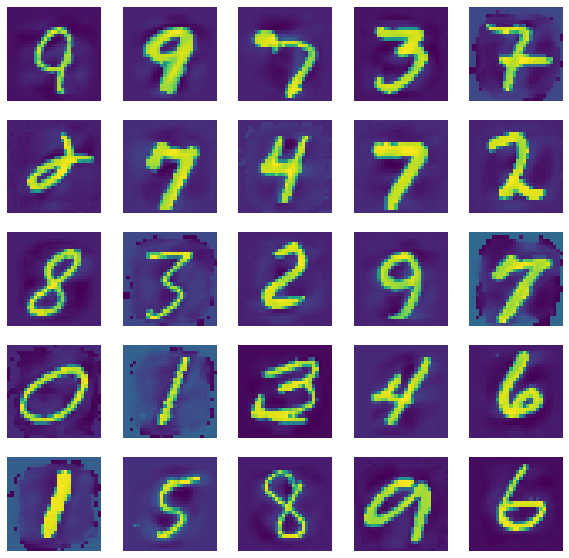

In [31]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

### Train with 
*02.4_MetricTransf_epsilon_..*

In [691]:
class DistanceTransform_MinExp_epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers+1)*3/3))
        self.bias = nn.Parameter(torch.ones(1, num_centers+1)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-(dists.abs())+self.scaler)
        dists = (1-dists)*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [702]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_MinExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim+1, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
#         self.activ = nn.ReLU()
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
#         print(torch.count_nonzero(xo.max(dim=1)[1] == 100))
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [703]:
learning_rate = 0.0001
EPOCHS = 10

In [704]:
model = LocalMLP_epsilonsoftmax(784, H, 10, epsilon=15.0).to(device)
model_name = f"LocalMLP_h{H}"
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_MinExp_epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=101, out_features=10, bias=True)
)

In [705]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [706]:
model.layer0.centers.data = source.type(torch.float32)/128-1

In [707]:
targets = torch.zeros(len(target), 10)
for i, t in enumerate(target):
    targets[i, t] = 1.

targets = torch.cat([targets, torch.randn(1, 10)*0.01], dim=0)
targets.shape

torch.Size([101, 10])

In [708]:
model.layer1.weight.data = targets.t()#.to(device)

In [709]:
for xx, yy in train_loader:
    xx = xx.reshape(-1, 784).to(device)
    break

In [710]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 101])
tensor([3.0828e-04, 1.0315e-04, 1.9598e-02, 2.8497e-03, 7.5522e-04, 1.3802e-05,
        8.2067e-03, 3.8816e-04, 1.5159e-02, 4.4253e-03, 9.6721e-06, 8.5352e-04,
        6.9254e-03, 3.2233e-03, 2.2461e-03, 7.3933e-03, 1.4320e-02, 1.2146e-03,
        2.9648e-04, 7.3128e-03, 1.6947e-03, 1.1643e-03, 6.0676e-03, 1.8469e-02,
        1.2571e-04, 6.1014e-05, 2.2287e-02, 5.4061e-02, 1.8182e-02, 7.1293e-03,
        7.7420e-04, 2.4213e-03, 1.8466e-02, 1.3724e-02, 1.3693e-02, 6.9511e-03,
        4.3537e-03, 1.1512e-02, 4.2084e-02, 3.9829e-03, 5.2675e-02, 2.0816e-02,
        1.6910e-02, 1.5158e-03, 1.0018e-04, 3.3636e-03, 3.5017e-04, 1.7953e-04,
        1.7119e-02, 2.9513e-04, 2.3657e-03, 1.3444e-03, 8.2252e-04, 1.8268e-02,
        1.5495e-02, 1.9749e-02, 1.0425e-02, 2.8093e-03, 1.2968e-04, 2.0654e-02,
        1.1911e-03, 6.1357e-04, 1.6437e-04, 1.2177e-03, 1.8867e-02, 8.7881e-03,
        1.0305e-04, 1.0298e-03, 8.5993e-03, 1.2732e-03, 1.3346e-03, 1.6961e-02,
        4.2811e-05

In [711]:
test(-1, model, model_name)

100%|██████████| 200/200 [00:01<00:00, 156.54it/s]

[Test] -1 Loss: 1.891 | Acc: 67.990 6799/10000


In [712]:
xx

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [713]:
# asdasd

In [714]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name)
    scheduler.step()

100%|██████████| 1200/1200 [00:09<00:00, 126.92it/s]


[Train] 0 Loss: 1.768 | Acc: 74.942 44965/60000


100%|██████████| 200/200 [00:01<00:00, 156.14it/s]


[Test] 0 Loss: 1.646 | Acc: 79.850 7985/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 127.12it/s]


[Train] 1 Loss: 1.578 | Acc: 80.620 48372/60000


100%|██████████| 200/200 [00:01<00:00, 123.99it/s]


[Test] 1 Loss: 1.500 | Acc: 82.740 8274/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 114.00it/s]


[Train] 2 Loss: 1.458 | Acc: 82.927 49756/60000


100%|██████████| 200/200 [00:01<00:00, 128.40it/s]


[Test] 2 Loss: 1.394 | Acc: 84.300 8430/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 114.65it/s]


[Train] 3 Loss: 1.363 | Acc: 84.195 50517/60000


100%|██████████| 200/200 [00:01<00:00, 133.03it/s]


[Test] 3 Loss: 1.309 | Acc: 85.390 8539/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 120.27it/s]


[Train] 4 Loss: 1.287 | Acc: 85.020 51012/60000


100%|██████████| 200/200 [00:01<00:00, 132.07it/s]


[Test] 4 Loss: 1.242 | Acc: 86.140 8614/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 109.46it/s]


[Train] 5 Loss: 1.229 | Acc: 85.678 51407/60000


100%|██████████| 200/200 [00:01<00:00, 119.99it/s]


[Test] 5 Loss: 1.193 | Acc: 86.650 8665/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 101.34it/s]


[Train] 6 Loss: 1.187 | Acc: 86.082 51649/60000


100%|██████████| 200/200 [00:01<00:00, 121.53it/s]


[Test] 6 Loss: 1.160 | Acc: 86.990 8699/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 100.95it/s]


[Train] 7 Loss: 1.161 | Acc: 86.335 51801/60000


100%|██████████| 200/200 [00:01<00:00, 127.87it/s]


[Test] 7 Loss: 1.140 | Acc: 87.130 8713/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 109.47it/s]


[Train] 8 Loss: 1.147 | Acc: 86.467 51880/60000


100%|██████████| 200/200 [00:01<00:00, 101.26it/s]


[Test] 8 Loss: 1.131 | Acc: 87.220 8722/10000
Saving..


100%|██████████| 1200/1200 [00:20<00:00, 58.75it/s]


[Train] 9 Loss: 1.141 | Acc: 86.512 51907/60000


100%|██████████| 200/200 [00:02<00:00, 76.75it/s]

[Test] 9 Loss: 1.129 | Acc: 87.230 8723/10000
Saving..


In [519]:
float(best_acc)

78.5

In [520]:
# model.layer0.centers.shape

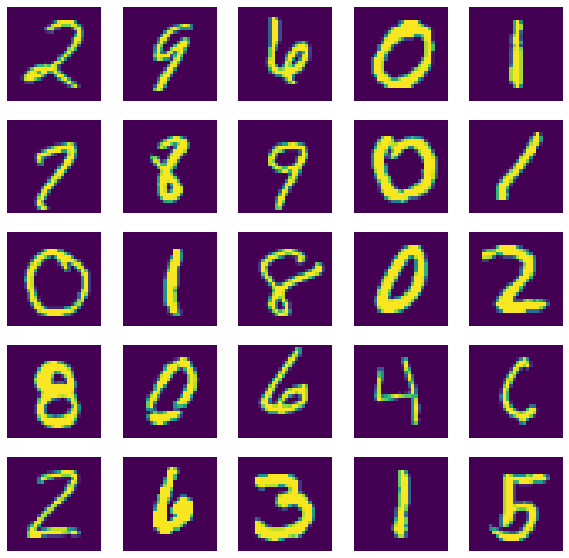

In [521]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

## Analyze the confidence of neurons along with epsilon

In [522]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        xo = model.layer0(inputs)
        xo = model.scale_shift(xo)
        xo = model.softmax(xo).data
        break

  0%|          | 0/200 [00:00<?, ?it/s]


In [523]:
j = 5
nearest = torch.argsort(xo[j], descending=True)
nearest

tensor([ 47,  37,  77,  96,  72,  11,  23,  59,   4,  48,  79,  78,   6,  40,
          9,   1, 100,  52,  36,  27,  76,   5,  68,  18,  67,  38,  41,  82,
         61,  56,  46,  86,  53,   7,  63,  19,  43,  71,  91,  20,  84,  57,
         60,  65,  75,  12,  90,  73,  98,  14,  55,  97,  66,  17,  42,  58,
          0,  92,  94,  62,   2,  54,  28,  88,  35,  31,  87,  29,  50,  32,
         30,  24,  70,  25,  99,  26,  89,  69,  33,  16,  10,  80,  85,  64,
         21,  74,  45,  93,  81,  44,  34,  15,  95,  22,  51,  13,   3,  49,
         39,   8,  83])

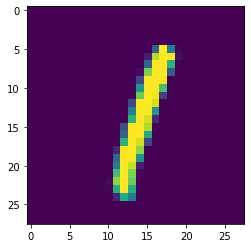

In [524]:
i = -1
plt.imshow(inputs[j].reshape(28,28))

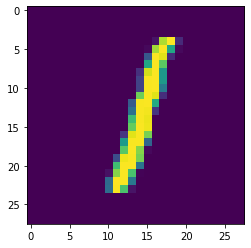

In [525]:
### Run iteratively
i+=1
plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))

In [526]:
model.layer0.centers.shape

torch.Size([100, 784])

In [527]:
## For centers, the actv
inputs = model.layer0.centers.data.clone()
with torch.no_grad():
    xo = model.layer0(inputs)
#     xo = model.scale_shift(xo)
#     xo = model.softmax(xo).data

In [528]:
# plt.imshow(xo)
xo

tensor([[ 1.0000, -5.4692, -5.3691,  ..., -5.8581, -6.7721, -3.9607],
        [-4.6042,  1.0000, -4.0295,  ..., -4.3883, -5.0202, -3.2974],
        [-4.9775, -4.4489,  1.0000,  ..., -4.8170, -5.9625, -3.6557],
        ...,
        [-6.3867, -5.9159, -6.5118,  ..., -6.2934, -6.7571, -4.3266],
        [-5.3164, -4.7287, -4.7085,  ...,  1.0000, -5.5406, -3.5689],
        [-7.4039, -6.5144, -7.0216,  ..., -6.6789,  1.0000, -4.3640]])

#### Test for random image sample

In [529]:
with torch.no_grad():
    inputs = torch.rand(10, 28*28).to(device)*2-1
#     inputs = torch.randn(10, 28*28).to(device)*0.7
    xo = model.layer0(inputs)
#     xo = model.scale_shift(xo)
#     xo = model.softmax(xo).data

In [530]:
# xo.argmax(dim=1)
xo.max(dim=1)

torch.return_types.max(values=tensor([-7.7624, -8.1835, -7.6889, -8.0997, -7.5991, -8.2283, -8.0031, -8.5863,
        -7.8681, -8.0488]), indices=tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

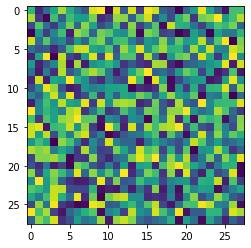

In [531]:
j=0
plt.imshow(inputs[j].reshape(28,28))

In [532]:
i = -1
nearest = torch.argsort(xo[0], descending=True)
nearest

tensor([100,  99,  81,  25,  64,  70,  58,   0,  87,  84,  45,  94,   8,  10,
         62,  57,  18,   2,  44,  95,  16,  54,  82,  63,  31,  46,  17,  66,
         24,  53,  73,  56,  22,  43,  33,   3,  88,  12,  51,  76,  49,  13,
         39,  14,  79,  27,  71,   7,  80,  35,  68,  36,  93,  28,  20,  92,
         75,  74,  50,  19,  67,  30,  97,  98,  90,  61,  69,  89,  85,  26,
          1,   5,  21,  83,  34,  32,  15,  38,  42,  60,  91,  86,  52,  11,
         29,  55,  48,  23,  40,  65,   4,   6,  47,  41,  96,  72,  78,  77,
         37,  59,   9])

tensor(-17.2060)

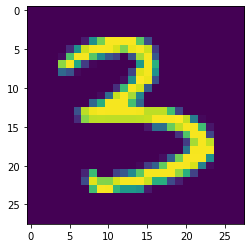

In [534]:
i+=1
plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))
xo[0][nearest[i]]

### Test with Adverserial Example

In [535]:
for xx, yy in test_loader:
    idx = np.random.randint(len(xx))
    xx = xx[idx].reshape(1, 784).to(device)
    yy = yy[idx].reshape(1,)

target_class = 7
advt = yy*0+target_class
print(yy, advt)

tensor([4]) tensor([7])


In [536]:
model.eval()

X = torch.autograd.Variable(xx, requires_grad=True)
yout = model(X)

tensor(0)


In [537]:
yout.shape

torch.Size([1, 10])

In [538]:
torch.argmax(yout.data.cpu(), dim=1), yy, advt

(tensor([4]), tensor([4]), tensor([7]))

In [539]:
loss = criterion(yout, advt.to(device))

xx_grad = torch.autograd.grad(outputs=loss, inputs=X,
                            only_inputs=True, retain_graph=True, create_graph=True)[0].data

In [540]:
xx_grad.min(), xx_grad.max()

(tensor(-0.0087), tensor(0.0062))

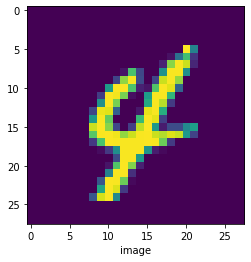

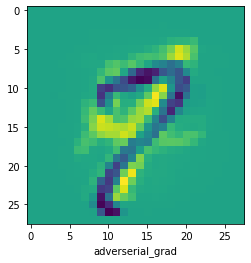

In [541]:
plt.imshow(xx.data.cpu().reshape(28,28))
plt.xlabel("image")
plt.show()
plt.imshow(xx_grad.data.cpu().reshape(28,28))
plt.xlabel("adverserial_grad")
plt.show()

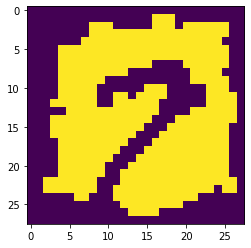

In [542]:
signed_grad = torch.sign(xx_grad.data.cpu())
plt.imshow(signed_grad.reshape(28,28))

In [543]:
1/xx_grad.data.norm()

tensor(18.9336)

In [544]:
epsilon = 1.0 #0.5
pertubation = xx - epsilon*signed_grad

# epsilon = 1/xx_grad.data.norm()*3
# pertubation = xx - epsilon*xx_grad.data

xx_adv = pertubation
xx_adv = torch.clamp(pertubation, -1, 1)

(tensor(-1.), tensor(1.))

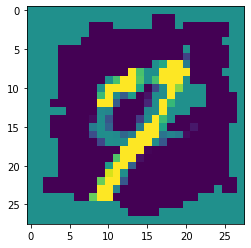

In [545]:
plt.imshow(xx_adv.reshape(28,28))
xx_adv.min(), xx_adv.max()

In [546]:
yy_adv = model(xx_adv.to(device))
yy_adv.argmax(dim=1), torch.argmax(yout.data, dim=1), yy, advt

tensor(1)


(tensor([3]), tensor([4]), tensor([4]), tensor([7]))

In [547]:
with torch.no_grad():
    inputs = xx_adv.to(device).view(-1, 28*28)
#     inputs = xx.to(device).view(-1, 28*28)

    xo = model.layer0(inputs)
    xo = model.scale_shift(xo)
    xo = model.softmax(xo).data
        
nearest = torch.argsort(xo[0], descending=True)
nearest

tensor([100,   5,  79,  78,   1,  38,  96,  91,  46,  72,   7,  27,  37,  52,
          9,  66,  88,  47,  59,  42,  40,  77,  92,  65,  90,   2,  28,  73,
         89,   4,  32,  64,  23,  48,  86,  61,  11,  97,  18,  41,  67,  85,
         17,  19,  16,  84,  76,  54,  50,  12,  36,  56,  71,  68,  26,  35,
          6,   0,  53,  21,  75,  43,  57,  94,  98,  62,  60,  29,  20,  82,
         31,  81,  63,  14,  13,  45,  34,  55,  30,  80,  69,  93,  24,  15,
         70,  44,  25,  95,  58,  99,  33,  10,  87,  39,  74,  49,   3,  51,
         22,  83,   8])

In [548]:
i = -1

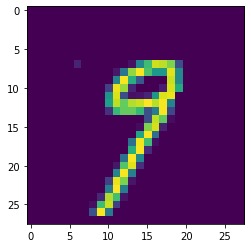

In [551]:
### Run iteratively
i+=1
plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))

### Compare Adverserial Examples with Linear-Transform and DT without epsilon softmax.
#### Benchmark

In [552]:
import foolbox as fb
import foolbox.attacks as fa

#### epsilon-Softmax

In [670]:
model.layer0.epsilon = 15.

In [671]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# epsilons = [0.5]

In [672]:
fmodel.device

device(type='cpu')

In [673]:
images, labels = [], []
for i, (xx, yy) in enumerate(test_loader):
    images.append(xx.reshape(-1, 28*28))
    labels.append(yy)
    if i*batch_size > 500: break
    
images, labels = torch.cat(images), torch.cat(labels)
images, labels = images.to(device), labels.to(device)

In [674]:
len(images)

600

In [675]:
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [591]:
588/600

0.98

In [563]:
success.shape

torch.Size([1, 600])

In [676]:
for i, eps in enumerate(epsilons):
    s = torch.count_nonzero(success[i])/torch.numel(success[i])
    print(f"Eps: {eps} ;\t success: {s:.3f} ")

Eps: 0.0 ;	 success: 0.082 
Eps: 0.001 ;	 success: 0.083 
Eps: 0.01 ;	 success: 0.105 
Eps: 0.03 ;	 success: 0.172 
Eps: 0.1 ;	 success: 0.572 
Eps: 0.3 ;	 success: 0.993 
Eps: 0.5 ;	 success: 1.000 
Eps: 1.0 ;	 success: 1.000 


In [ ]:
"""
Changing epsilon on model changes rejection ratio..
"""

#### Softmax

In [665]:
class LocalMLPsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = dtnn.DistanceTransform(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = dtnn.DistanceTransform_MinExp(self.input_dim, self.hidden_dim, bias=True)
#         self.layer0 = nn.Linear(self.input_dim, self.hidden_dim, bias=True)
        
#         self.scale_shift = dtnn.ScaleShift(self.hidden_dim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
#         self.softmax = nn.Softmax(dim=-1)
#         self.softmax = nn.LogSoftmax(dim=-1)
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='relu')
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = nn.ReLU()
        self.layer1 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
#         xo = self.scale_shift(xo)
#         xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [666]:
model = LocalMLPsoftmax(784, H, 10).to(device)
model_name = f"LocalMLP_h{H}"
model

LocalMLPsoftmax(
  (layer0): DistanceTransform()
  (activ): ReLU()
  (layer1): Linear(in_features=100, out_features=10, bias=True)
)

In [594]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [595]:
model.layer0.centers.data = source.type(torch.float32)/128-1
# model.layer0.weight.data = source.type(torch.float32)/128-1

AttributeError: 'Linear' object has no attribute 'centers'

In [441]:
targets = torch.zeros(len(target), 10)
for i, t in enumerate(target):
    targets[i, t] = 1.

targets.shape

torch.Size([100, 10])

In [442]:
model.layer1.weight.data = targets.t()#.to(device)

In [667]:
test(-1, model, model_name)

100%|██████████| 200/200 [00:01<00:00, 156.30it/s]

[Test] -1 Loss: 2.367 | Acc: 12.380 1238/10000


In [668]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name)
    scheduler.step()

100%|██████████| 1200/1200 [00:08<00:00, 141.69it/s]


[Train] 0 Loss: 1.349 | Acc: 67.098 40259/60000


100%|██████████| 200/200 [00:01<00:00, 152.09it/s]


[Test] 0 Loss: 0.738 | Acc: 84.860 8486/10000
Saving..


100%|██████████| 1200/1200 [00:08<00:00, 142.20it/s]


[Train] 1 Loss: 0.597 | Acc: 86.288 51773/60000


100%|██████████| 200/200 [00:01<00:00, 138.83it/s]


[Test] 1 Loss: 0.471 | Acc: 88.710 8871/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 126.27it/s]


[Train] 2 Loss: 0.434 | Acc: 88.898 53339/60000


100%|██████████| 200/200 [00:01<00:00, 138.98it/s]


[Test] 2 Loss: 0.377 | Acc: 90.160 9016/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 124.21it/s]


[Train] 3 Loss: 0.366 | Acc: 90.145 54087/60000


100%|██████████| 200/200 [00:01<00:00, 134.68it/s]


[Test] 3 Loss: 0.330 | Acc: 91.140 9114/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 127.12it/s]


[Train] 4 Loss: 0.328 | Acc: 90.890 54534/60000


100%|██████████| 200/200 [00:01<00:00, 128.78it/s]


[Test] 4 Loss: 0.305 | Acc: 91.410 9141/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 123.73it/s]


[Train] 5 Loss: 0.306 | Acc: 91.350 54810/60000


100%|██████████| 200/200 [00:01<00:00, 147.94it/s]


[Test] 5 Loss: 0.288 | Acc: 91.980 9198/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 123.00it/s]


[Train] 6 Loss: 0.292 | Acc: 91.712 55027/60000


100%|██████████| 200/200 [00:01<00:00, 129.90it/s]


[Test] 6 Loss: 0.279 | Acc: 92.070 9207/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 123.76it/s]


[Train] 7 Loss: 0.283 | Acc: 91.967 55180/60000


100%|██████████| 200/200 [00:01<00:00, 147.52it/s]


[Test] 7 Loss: 0.274 | Acc: 92.320 9232/10000
Saving..


100%|██████████| 1200/1200 [00:09<00:00, 122.94it/s]


[Train] 8 Loss: 0.279 | Acc: 92.040 55224/60000


100%|██████████| 200/200 [00:01<00:00, 103.96it/s]


[Test] 8 Loss: 0.271 | Acc: 92.230 9223/10000


100%|██████████| 1200/1200 [00:11<00:00, 108.68it/s]


[Train] 9 Loss: 0.277 | Acc: 92.118 55271/60000


100%|██████████| 200/200 [00:01<00:00, 128.53it/s]

[Test] 9 Loss: 0.270 | Acc: 92.290 9229/10000


In [669]:
float(best_acc)

92.32

In [446]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [447]:
images, labels = [], []
for i, (xx, yy) in enumerate(test_loader):
    images.append(xx.reshape(-1, 28*28))
    labels.append(yy)
    if i*batch_size > 500: break
    
images, labels = torch.cat(images), torch.cat(labels)
images, labels = images.to(device), labels.to(device)

In [448]:
attack_criteria = fb.criteria.Misclassification(labels)
# attack_criteria

In [449]:
# _, advs, success = attack(fmodel, images, attack_criteria, epsilons=epsilons)
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [450]:
for i, eps in enumerate(epsilons):
    s = torch.count_nonzero(success[i])/torch.numel(success[i])
    print(f"Eps: {eps} ;\t success: {s:.3f} ")

Eps: 0.0 ;	 success: 0.235 
Eps: 0.001 ;	 success: 0.235 
Eps: 0.01 ;	 success: 0.250 
Eps: 0.03 ;	 success: 0.267 
Eps: 0.1 ;	 success: 0.328 
Eps: 0.3 ;	 success: 0.460 
Eps: 0.5 ;	 success: 0.552 
Eps: 1.0 ;	 success: 0.673 


## TODO

In [ ]:
"""
Create MLP with feature to reject examples (maybe with 11th class for uncertainity)
"""